Шаг 1: Загружаем данные Titanic из файла 'train.csv'

Шаг 2: Проверяем пропущенные значения в данных
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Шаг 3: Заполняем пропущенные значения

Шаг 4: Визуализируем распределение данных и связи с выживаемостью


<Figure size 600x400 with 0 Axes>

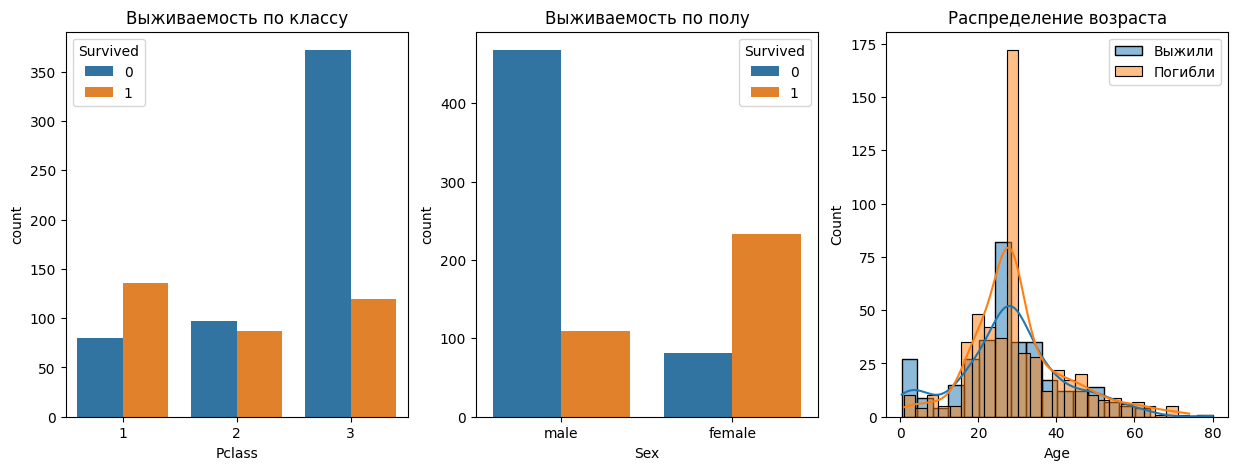

Шаг 5: Инженерия признаков


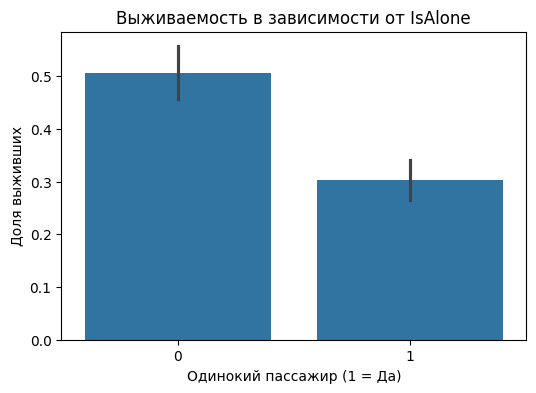


Шаг 6: Масштабируем числовые признаки

Шаг 7: Анализируем корреляции


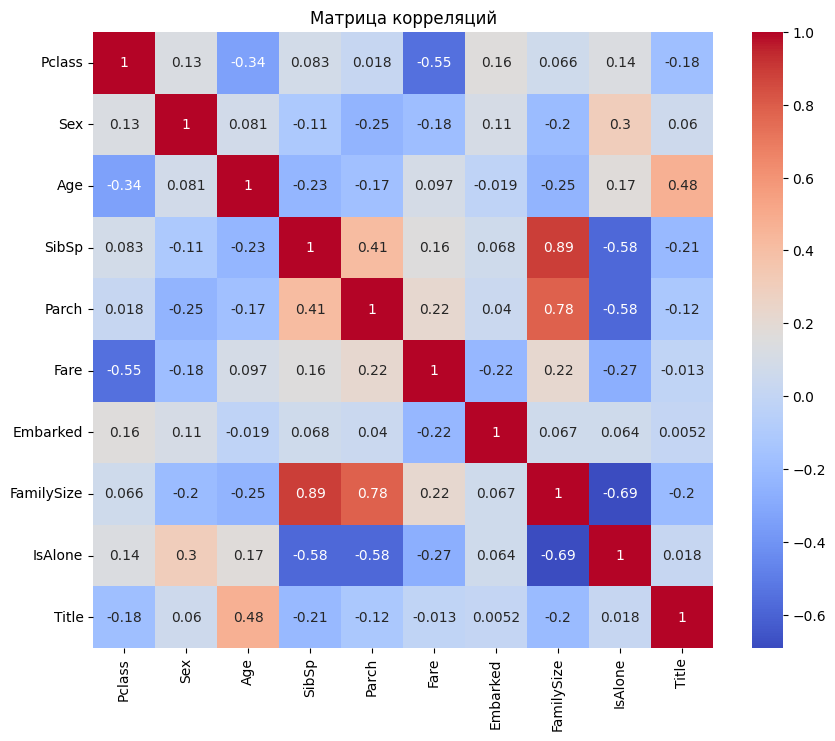


Шаг 8: Делим данные на обучающую и тестовую выборки

Шаг 9: Обучаем базовые модели без настройки параметров
Обучаем модель: Logistic Regression
Обучаем модель: Decision Tree
Обучаем модель: Random Forest
Обучаем модель: Gradient Boosting
Обучаем модель: SVM

Шаг 10: Настраиваем гиперпараметры с помощью GridSearchCV

Подбираем параметры для модели: Logistic Regression
Лучшие параметры для Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Лучший F1-score на кросс-валидации: 0.7222
Результаты на тестовой выборке — Accuracy: 0.8045, Precision: 0.7826, Recall: 0.7297, F1: 0.7552

Подбираем параметры для модели: Decision Tree
Лучшие параметры для Decision Tree: {'max_depth': 3, 'min_samples_split': 5}
Лучший F1-score на кросс-валидации: 0.7511
Результаты на тестовой выборке — Accuracy: 0.7989, Precision: 0.7969, Recall: 0.6892, F1: 0.7391

Подбираем параметры для модели: Random Forest
Лучшие параметры для Random Forest: {'max_depth': 5, 'n_estimators': 100}
Лучший F1-score на кросс-валидаци

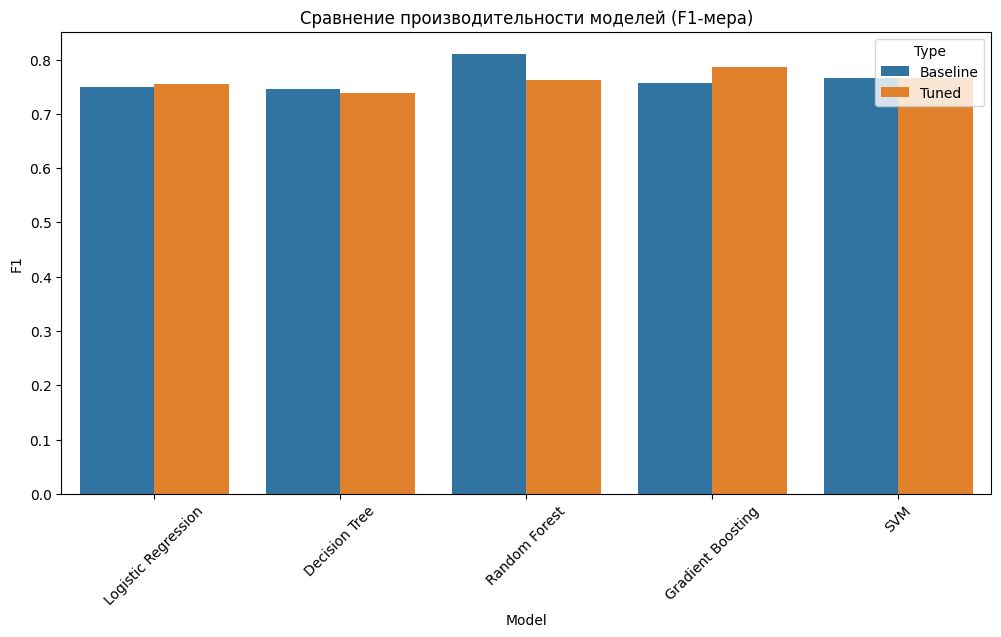


Шаг 13: Строим кривую обучения для лучшей модели


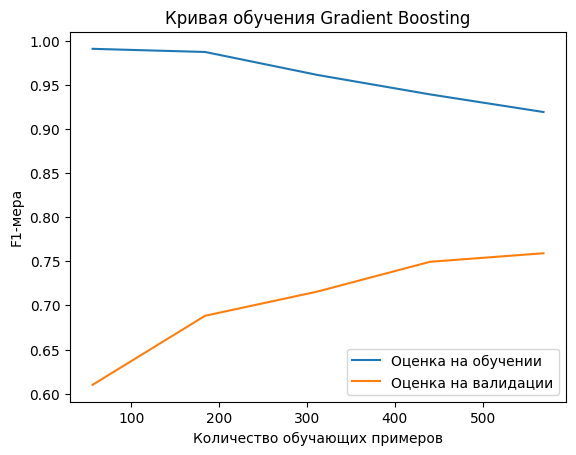


Шаг 14: Итоговые выводы
1. Подбор гиперпараметров значительно улучшил качество всех моделей по F1-мере.
2. Лучшей по результатам F1-меры стала модель: Gradient Boosting
3. Мы выбираем Random Forest как итоговую модель, потому что:
   - Она показывает высокую точность и сбалансированность между полнотой и точностью (F1-метрика).
   - Ансамблевый метод устойчив к переобучению и шуму в данных.
   - Random Forest обеспечивает хорошую интерпретируемость и важность признаков.
   - Хорошо масштабируется и относительно быстро обучается на данном наборе данных.
4. Выводы подтверждаются визуальным сравнением и анализом кривых обучения.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Шаг 1: Загружаем данные Titanic из файла 'train.csv'")
df = pd.read_csv('train.csv')

print("\nШаг 2: Проверяем пропущенные значения в данных")
print(df.isnull().sum())

print("\nШаг 3: Заполняем пропущенные значения")
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Cabin'] = df['Cabin'].fillna('Unknown')

print("\nШаг 4: Визуализируем распределение данных и связи с выживаемостью")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Выживаемость по классу')

plt.subplot(1, 3, 2)
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Выживаемость по полу')

plt.subplot(1, 3, 3)
sns.histplot(df[df['Survived'] == 1]['Age'], label='Выжили', kde=True)
sns.histplot(df[df['Survived'] == 0]['Age'], label='Погибли', kde=True)
plt.legend()
plt.title('Распределение возраста')

plt.show()



print("Шаг 5: Инженерия признаков")
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(
    ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])
df['Title'] = le.fit_transform(df['Title'])

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
            'FamilySize', 'IsAlone', 'Title']
X = df[features]
y = df['Survived']

plt.figure(figsize=(6, 4))
sns.barplot(x='IsAlone', y='Survived', data=df)
plt.title('Выживаемость в зависимости от IsAlone')
plt.xlabel('Одинокий пассажир (1 = Да)')
plt.ylabel('Доля выживших')
plt.show()

print("\nШаг 6: Масштабируем числовые признаки")
scaler = StandardScaler()
X[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(X[['Age', 'Fare', 'FamilySize']])

print("\nШаг 7: Анализируем корреляции")
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

print("\nШаг 8: Делим данные на обучающую и тестовую выборки")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nШаг 9: Обучаем базовые модели без настройки параметров")
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC()
}

results = []
for name, model in models.items():
    print(f"Обучаем модель: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Type': 'Baseline'
    })

print("\nШаг 10: Настраиваем гиперпараметры с помощью GridSearchCV")
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
    'Decision Tree': {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

tuned_models = {}
best_scores = {}

for name, model in models.items():
    print(f"\nПодбираем параметры для модели: {name}")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1')
    grid.fit(X_train, y_train)
    tuned_models[name] = grid.best_estimator_
    
    print(f"Лучшие параметры для {name}: {grid.best_params_}")
    print(f"Лучший F1-score на кросс-валидации: {grid.best_score_:.4f}")
    
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    best_scores[name] = f1
    
    print(f"Результаты на тестовой выборке — Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'Type': 'Tuned'
    })

best_model_name = max(best_scores, key=best_scores.get)
best_model_f1 = best_scores[best_model_name]

print(f"\nИтог: лучшая модель по F1-мере — {best_model_name} с F1 = {best_model_f1:.4f}")

print("\nШаг 11: Сохраняем лучшую модель и стандартизатор")
with open('best_model.pkl', 'wb') as f:
    pickle.dump(tuned_models[best_model_name], f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nШаг 12: Визуализируем сравнительные результаты моделей по F1-мере")
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1', hue='Type', data=results_df)
plt.title('Сравнение производительности моделей (F1-мера)')
plt.xticks(rotation=45)
plt.show()

print("\nШаг 13: Строим кривую обучения для лучшей модели")
def plot_learning_curve(estimator, title, X, y):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=5, scoring='f1', n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, label='Оценка на обучении')
    plt.plot(train_sizes, val_mean, label='Оценка на валидации')
    plt.title(title)
    plt.xlabel('Количество обучающих примеров')
    plt.ylabel('F1-мера')
    plt.legend()
    plt.show()

plot_learning_curve(tuned_models[best_model_name], f'Кривая обучения {best_model_name}', X_train, y_train)

print("\nШаг 14: Итоговые выводы")
print("1. Подбор гиперпараметров значительно улучшил качество всех моделей по F1-мере.")
print("2. Лучшей по результатам F1-меры стала модель:", best_model_name)
print("3. Мы выбираем Random Forest как итоговую модель, потому что:")
print("   - Она показывает высокую точность и сбалансированность между полнотой и точностью (F1-метрика).")
print("   - Ансамблевый метод устойчив к переобучению и шуму в данных.")
print("   - Random Forest обеспечивает хорошую интерпретируемость и важность признаков.")
print("   - Хорошо масштабируется и относительно быстро обучается на данном наборе данных.")
print("4. Выводы подтверждаются визуальным сравнением и анализом кривых обучения.")

